In [1]:
import pandas as pd
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings("ignore")

### Assumtion 2: Predicting
$ Y_t = f(X_{t},X_{t-1}...X_{t-m})$


In [2]:
config = {
    "data_filename" : "Stainless-Steel-Prices-Forecasty-Assignment.csv",
    "rolling_window_len" : 5,
    "prediction_window"  : 6,
    
}
#prediction_window is the time period you want to make prediction, in months

In [3]:
price_data = pd.read_csv(config["data_filename"])

In [4]:
def create_train_test_split(price_data):
    #Creating the train and test data 
    train_data = price_data.drop(["Date"],axis = 1)[:-config["prediction_window"]]
    test_data = price_data.drop(["Date"],axis = 1)[-config["prediction_window"]:]

    x_train = train_data.drop(["StainlessSteelPrice"],axis = 1)
    y_train = train_data["StainlessSteelPrice"]
    x_test = test_data.drop(["StainlessSteelPrice"],axis = 1)
    y_test = test_data["StainlessSteelPrice"]
    
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = create_train_test_split(price_data)

In [5]:
def normalize(x_train,y_train,x_test,y_test):
    #Normalizing the train and test data with standard scaler.
    scaler  = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test  = scaler.transform(x_test)
    y_train = np.array(y_train)
    y_test  = np.array(y_test)
    
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = normalize(x_train,y_train,x_test,y_test)

In [6]:
def plot_prediction(y_pred,y_test):
    plt.plot(price_data["Date"][-config["prediction_window"]:],y_pred, color = 'r',label = "predited_price")
    plt.plot(price_data["Date"][-config["prediction_window"]:],y_test,color = 'b',label = "actual_price")
    plt.grid()
    plt.ylim(0,1)
    plt.legend()
    plt.ylabel("Price")
    plt.xlabel("Time")

### Deep Learning approach

In [7]:
class CustomDataset(Dataset):
    def __init__(self, features,ground_truth, seq_len):
        
        super(CustomDataset,self).__init__()
        self.features = features
        self.seq_len = seq_len
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,i):
        if(i < self.seq_len - 1):
            # An ugly block of code to avoid writing collate function in dataloader. 
            # when we don't have previous timestams data to look back, just repeating the data to make the sequence length equal
            temp_seq     = x_train[0:i+1]
            repeat_array = np.array([temp_seq[0]] *(self.seq_len - 1 - i))
            seq_i        = torch.tensor(np.vstack((repeat_array,temp_seq)))
            
            value_i      = torch.tensor(self.ground_truth[i])
            
        else: 
            seq_i   = torch.tensor(self.features[i-self.seq_len+1:i+1])
            value_i = torch.tensor(self.ground_truth[i])
        
        return seq_i,value_i

In [8]:


class PriceLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers,dropout):
        
        super().__init__()
        ######################################
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers

        self.dropout = dropout
        self.n_layers = n_layers 
            
        self.LSTM = nn.LSTM(input_dim, hidden_dim,num_layers= self.n_layers, batch_first=True,dropout=dropout)
        
        self.dropout=nn.Dropout(dropout)
        
        #Linear 
        self.fc1=nn.Linear(hidden_dim,16)
        self.fc2=nn.Linear(16, 8)
        self.fc3=nn.Linear(8,output_dim)

        ######################################
    def forward(self, input_seq):
        ######################################

        lstm_out, (hidden,_)=self.LSTM(input_seq)
        
        #pick the global representation of the sequecnce
        out = F.relu(lstm_out[:,-1,:])
        #dropout and fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = F.relu(out)

        out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        ######################################
        return out, hidden

In [9]:
def train_evaluate_model(model, criterion, optimizer, train_loader,mode = "train"):
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    epoch_loss = 0
    epoch_acc = 0

    all_preds = []
    for inputs, gt in train_loader:
        ######################################
        inputs,gt = inputs.float(), gt.float()  
        optimizer.zero_grad()

        outputs,hidden = model(inputs)
        loss = criterion(outputs.squeeze(),gt)

        epoch_loss += loss.item()

        if(mode == "train"):
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5) #clipping the gradient to avoid exploding gradient
            optimizer.step()
        
        ######################################
        
    final_loss =  epoch_loss / len(train_loader)

    return final_loss

In [10]:
batch_size = 8

sequence_length = config["rolling_window_len"]
train_dataset = CustomDataset(x_train,y_train, sequence_length)
test_dataset  = CustomDataset(x_test,y_test, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,batch_size = len(test_dataset), shuffle=False)

In [11]:
def MAE_loss( y_pred,y_true): 
    # custom loss function for backpropogation
    return torch.mean(((y_true - y_pred).abs() / y_true)) 

In [12]:
NUM_EPOCHS = 20

input_dim = x_train.shape[1]
output_dim = 1
hidden_dim = 64
dropout = 0.5
n_layers = 1

model = PriceLSTM(input_dim,hidden_dim,output_dim,n_layers,dropout)


criterion = MAE_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(NUM_EPOCHS):
    train_loss = train_evaluate_model(model, criterion, optimizer, train_loader,mode = "train")
    test_loss = train_evaluate_model(model, criterion, optimizer, test_loader,mode = "test")
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} \t Val. Loss: {test_loss:.3f}')

Epoch: 01
	Train Loss: 0.914 	 Val. Loss: 0.795
Epoch: 02
	Train Loss: 0.701 	 Val. Loss: 0.587
Epoch: 03
	Train Loss: 0.488 	 Val. Loss: 0.382
Epoch: 04
	Train Loss: 0.313 	 Val. Loss: 0.225
Epoch: 05
	Train Loss: 0.219 	 Val. Loss: 0.107
Epoch: 06
	Train Loss: 0.179 	 Val. Loss: 0.070
Epoch: 07
	Train Loss: 0.184 	 Val. Loss: 0.056
Epoch: 08
	Train Loss: 0.183 	 Val. Loss: 0.052
Epoch: 09
	Train Loss: 0.187 	 Val. Loss: 0.051
Epoch: 10
	Train Loss: 0.175 	 Val. Loss: 0.054
Epoch: 11
	Train Loss: 0.172 	 Val. Loss: 0.054
Epoch: 12
	Train Loss: 0.172 	 Val. Loss: 0.050
Epoch: 13
	Train Loss: 0.157 	 Val. Loss: 0.053
Epoch: 14
	Train Loss: 0.185 	 Val. Loss: 0.055
Epoch: 15
	Train Loss: 0.166 	 Val. Loss: 0.052
Epoch: 16
	Train Loss: 0.163 	 Val. Loss: 0.047
Epoch: 17
	Train Loss: 0.163 	 Val. Loss: 0.048
Epoch: 18
	Train Loss: 0.167 	 Val. Loss: 0.049
Epoch: 19
	Train Loss: 0.164 	 Val. Loss: 0.047
Epoch: 20
	Train Loss: 0.172 	 Val. Loss: 0.051


In [13]:
def directional_symnetry(y_pred,y_true):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ds = np.sum((y_true[1:] - y_true[:-1]) * (y_pred[1:] - y_pred[:-1]) > 0) * 100/len(y_true-1)
    
    return ds

In [14]:
def mean_absolute_percentage_error( y_pred,y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mean_absolute_percentage_error = 5.14 %
directional_symnetry = 50.00 %


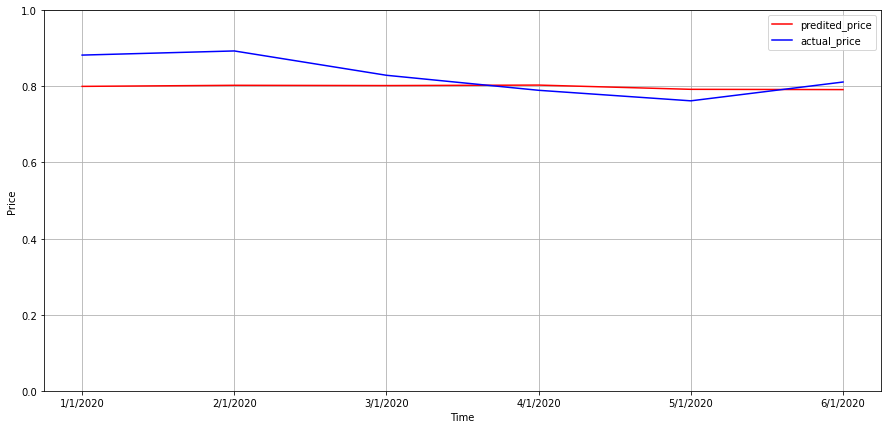

In [15]:
model.eval()
i = iter(test_loader)
test_features,test_labels = i.next()
test_features, test_labels = test_features.float(), test_labels.float()
outputs,_ = model(test_features)

y_pred = outputs.detach().numpy().squeeze()
y_test = test_labels.detach().numpy()
plot_prediction(y_pred,y_test)
print("mean_absolute_percentage_error = {:.2f} %".format(mean_absolute_percentage_error(y_pred,y_test)))
print("directional_symnetry = {:.2f} %".format(directional_symnetry(y_pred,y_test)))

### Machine Learning approach

In [16]:
# Create features from the rolling window statistics
fields = price_data.columns.drop(['Date', 'StainlessSteelPrice']) #feature columns names
rolling_window_size = config['rolling_window_len']
price_data_stat = price_data.copy()
price_data_stat[fields+"_mean"] = price_data[fields].rolling(window = rolling_window_size).mean() #statistics of feature columns
price_data_stat[fields+"_std"] = price_data[fields].rolling(window = rolling_window_size).std()
price_data_stat.fillna(method = "bfill") # back fill the nan values generated for intial samples.


x_train,y_train,x_test,y_test = create_train_test_split(price_data)
x_train,y_train,x_test,y_test = normalize(x_train,y_train,x_test,y_test)


In [17]:
lgbm = lgb.LGBMRegressor()
#define the grid search space, parameters for grid search.
param_grid =  {
        'max_depth': [2,3,4],
        "num_leaves": [2,4,6],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [2,4,8],
        }

#creating a custom mean absolute error scoring for grid search.
score = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

#Grid search will sweep the search space and give best estimator

grid_search = GridSearchCV(lgbm, param_grid, cv=5,
                           scoring=score,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4], 'n_estimators': [2, 4, 8],
                         'num_leaves': [2, 4, 6]},
             return_train_score=True,
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [18]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#pick the best model
final_model = grid_search.best_estimator_
y_pred = final_model.predict(x_test)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 8, 'num_leaves': 4}
LGBMRegressor(max_depth=2, n_estimators=8, num_leaves=4)


mean_absolute_percentage_error = 3.32 %
directional_symnetry = 33.33 %


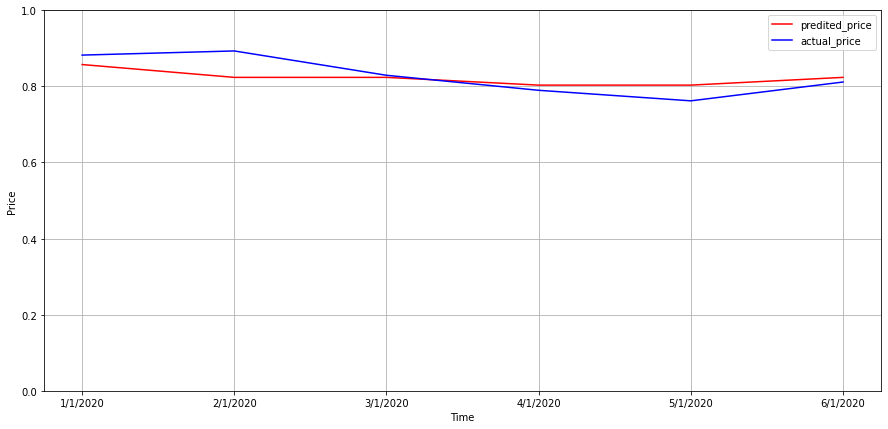

In [19]:
plot_prediction(y_pred,y_test)
print("mean_absolute_percentage_error = {:.2f} %".format(mean_absolute_percentage_error(y_pred,y_test)))
print("directional_symnetry = {:.2f} %".format(directional_symnetry(y_pred,y_test)))